In [115]:
# @title Quickstart for Google Colab
from pathlib import Path
import matplotlib.pyplot as plt

# Week 5: PCA

The exercise of this week is about PCA. Run this notebook on Colab [following this link](https://colab.research.google.com/github/tavisualcomputing/viscomp2023/blob/main/Exercises/W5/W5_exercise.ipynb).

First load the following libraries that will be necessary and extract the dataset archive:

In [116]:
!pip install scipy
!pip install scikit-image
!pip install matplotlib

In [117]:
%matplotlib inline
from skimage.io import imread
from scipy import signal,ndimage
import numpy as np
import time
import scipy.io as sio
from matplotlib.pyplot import imshow,show,figure,title,axis
import skimage.transform as tf
import IPython
import scipy
from sys import getsizeof

def make_grid(image_list,rows=5):
    cols = len(image_list)//rows
    row_image_list = []
    for c in range(cols):
        col_image_list = []
        for r in range(rows):
            col_image_list.append(image_list[c*rows+r])
        col_image = np.concatenate(col_image_list,axis=0)
        row_image_list.append(col_image)
    return np.concatenate(row_image_list,axis=1)

# Load images

We use the AT&T dataset, which consists of 40 people with 10 experssions each. We split the dataset into two parts, training images and test images. The training images will be used to extract the eigenfaces, which are then used to compress test images.

**First, we load the training data.** Here we take 5 expressions of 20 people as training set. 

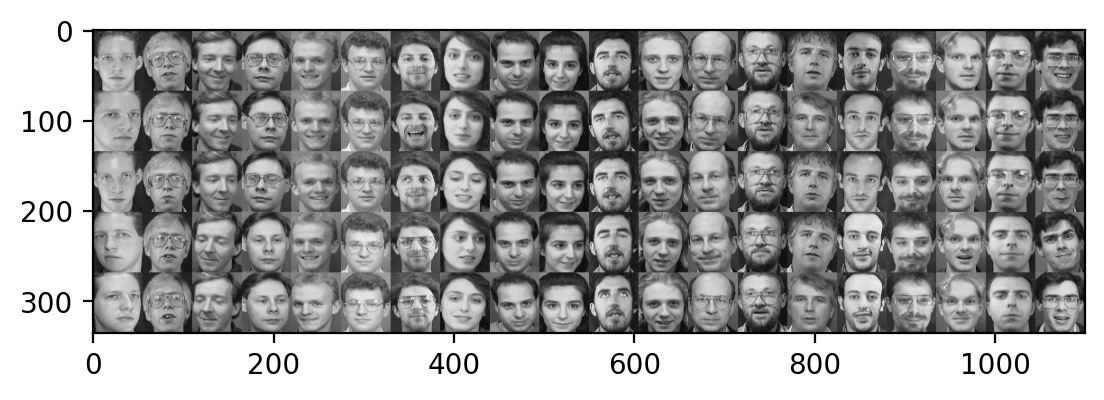

In [118]:
train_person_ids = np.arange(1,21)
train_expression_ids = np.arange(1,6)
train_image_list = []
for pid in train_person_ids:
    for eid in train_expression_ids:
        image = imread('dataset/s%d/%d.pgm'%(pid,eid))/255.
        image = tf.rescale(image,0.6)
        h,w = image.shape
        train_image_list.append(image)

train_image_collage = make_grid(train_image_list,rows=5)
figure(dpi=200)
imshow(train_image_collage,cmap='gray');

**Then we load the test images.** To see if the method can deal with unseen people and unseen expressions, we test with the rest 5 expressions of the rest 20 people.

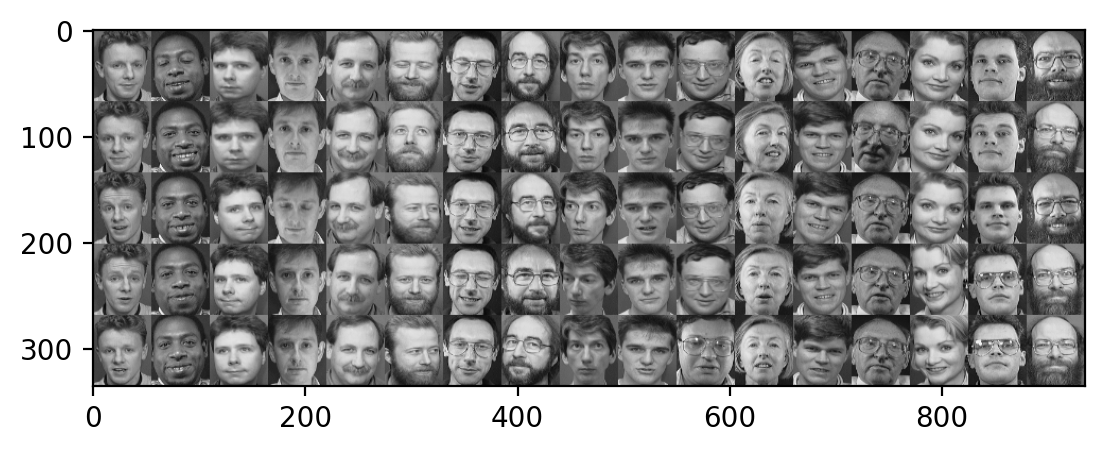

In [119]:
test_person_ids = np.arange(21,38)
test_expression_ids = np.arange(6,11)
test_image_list = []
for pid in test_person_ids:
    for eid in test_expression_ids:
        image = imread('dataset/s%d/%d.pgm'%(pid,eid))/255.
        image = tf.rescale(image,0.6)
        h,w = image.shape
        test_image_list.append(image)
        
test_image_collage = make_grid(test_image_list,rows=5)
figure(dpi=200)
imshow(test_image_collage,cmap='gray');

## Part A: Image Compression

In part A, we will use PCA to compress face images. For convenience we reshape the N training images into vectors of length $D = Height\times Width$ and concatenate all vectors to form a $D \times N$ matrix $X$.

In [120]:
image_vectors = [image.flatten() for image in train_image_list]
X = np.stack(image_vectors, axis=1)

**Compute the mean and covariance of images.** The mean of images $\mu$ is a vector of length $D$ and can be visualized as an image. The covariance $\Sigma$ is a $D \times D$ matrix. You can use `numpy.mean()` and `numpy.cov()` for the computation.

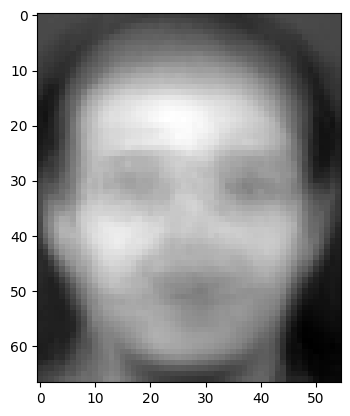

In [121]:
mean = np.mean(X, axis=1)
covariance = np.cov(X, rowvar=True)

imshow(mean.reshape(h,w),cmap='gray')

**Compute eigenfaces.** Eigenfaces are the eigenvectors correponding to k-largest eigenvalues of covariance matrix. You can use `scipy.sparse.linalg.eigs(mat,k)` to compute $k$ largest eigenvalues of $mat$ and corresponding eigenvectors $[u_1 ... u_k]$ . Note that this function returns complex valued results, which needs to be converted to real numbers using `numpy.real()`.

In [135]:
from IPython.display import clear_output
num_eigenvectors = 50
eigenvalues, eigenvectors = np.linalg.eigh(covariance)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvectors = eigenvectors[:, sorted_indices]

eigenvectors = eigenvectors[:, :num_eigenvectors]





/var/folders/hb/cwg273jd0r9clt27l45b9ktm0000gn/T/ipykernel_78219/484782085.py:25: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


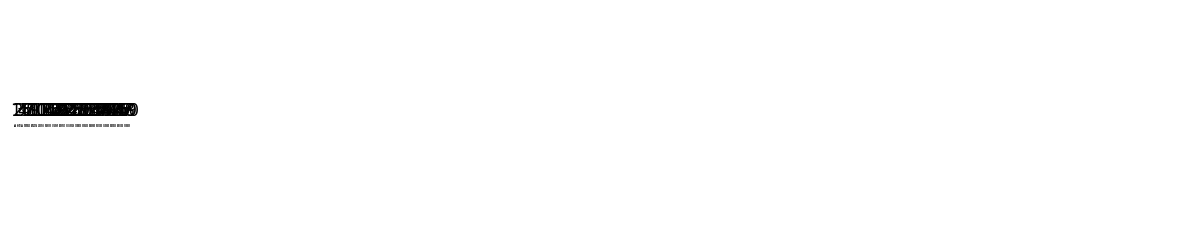

In [141]:

# 假设 eigenvectors 是已经得到的特征向量矩阵，h 和 w 是图像的高度和宽度
# 修改此部分代码以确保特征向量数量和图像大小设置正确

num_eigenvectors = eigenvectors.shape[1]  # 假设 eigenvectors 的列数是特征向量的数量

# 确定行和列的排列方式，例如每行显示 5 个特征向量
cols = 500
rows = num_eigenvectors // cols + int(num_eigenvectors % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))  # 根据行列数动态设置图像尺寸

for i, eigenvector in enumerate(eigenvectors.T):
    row, col = divmod(i, cols)
    
    ax = axes[row, col] if rows > 1 else axes[col]  # 处理只有一行或多行的情况
    ax.imshow(eigenvector.reshape(h, w), cmap='gray')
    ax.set_title(f"{i+1}")
    ax.axis('off')

# 如果特征向量数量不足以填满整个网格，隐藏多余的子图
for i in range(num_eigenvectors, rows * cols):
    row, col = divmod(i, cols)
    ax = axes[row, col] if rows > 1 else axes[col]
    ax.axis('off')

plt.tight_layout()
show()

**Now we can use the computed eigenfaces to compress images.** Face images can be approximated by linear combinations of eigenfaces $x=\mu + c_1 u_1 + c_2 u_2 + .... + c_k u_k$. Therefore, we can use the weights $[c_1 ... c_k]$ to record a image, instead of saving all pixels values. Each weight $c_i$ is the projection of the normalized image $\tilde{x} = x-\mu$ onto the corresponding eigenface $u_i$, which can be computed by dot product $c_i = \tilde{x} \cdot u_i$. 

To recover a image from its compression we can use  $x=\mu + c_1 u_1 + c_2 u_2 + .... + c_k u_k$.


**Complete the lines below to compress a image into a $k$ dimensional vector.**

**Q:** Compress training images and test images. On which set the method works better? Why?

**Q:** Compress image with different number of eigenfaces. What's the influence of $k$?

**Q:** Considering that we want to reduce data size, what is the maximum value of $k$?

Image 1: Size before compression: 29480 Bytes
Image 1: Size after compression: 400 Bytes
Image 2: Size before compression: 29480 Bytes
Image 2: Size after compression: 400 Bytes
Image 3: Size before compression: 29480 Bytes
Image 3: Size after compression: 400 Bytes
Image 4: Size before compression: 29480 Bytes
Image 4: Size after compression: 400 Bytes
Image 5: Size before compression: 29480 Bytes
Image 5: Size after compression: 400 Bytes
Image 6: Size before compression: 29480 Bytes
Image 6: Size after compression: 400 Bytes
Image 7: Size before compression: 29480 Bytes
Image 7: Size after compression: 400 Bytes
Image 8: Size before compression: 29480 Bytes
Image 8: Size after compression: 400 Bytes
Image 9: Size before compression: 29480 Bytes
Image 9: Size after compression: 400 Bytes
Image 10: Size before compression: 29480 Bytes
Image 10: Size after compression: 400 Bytes


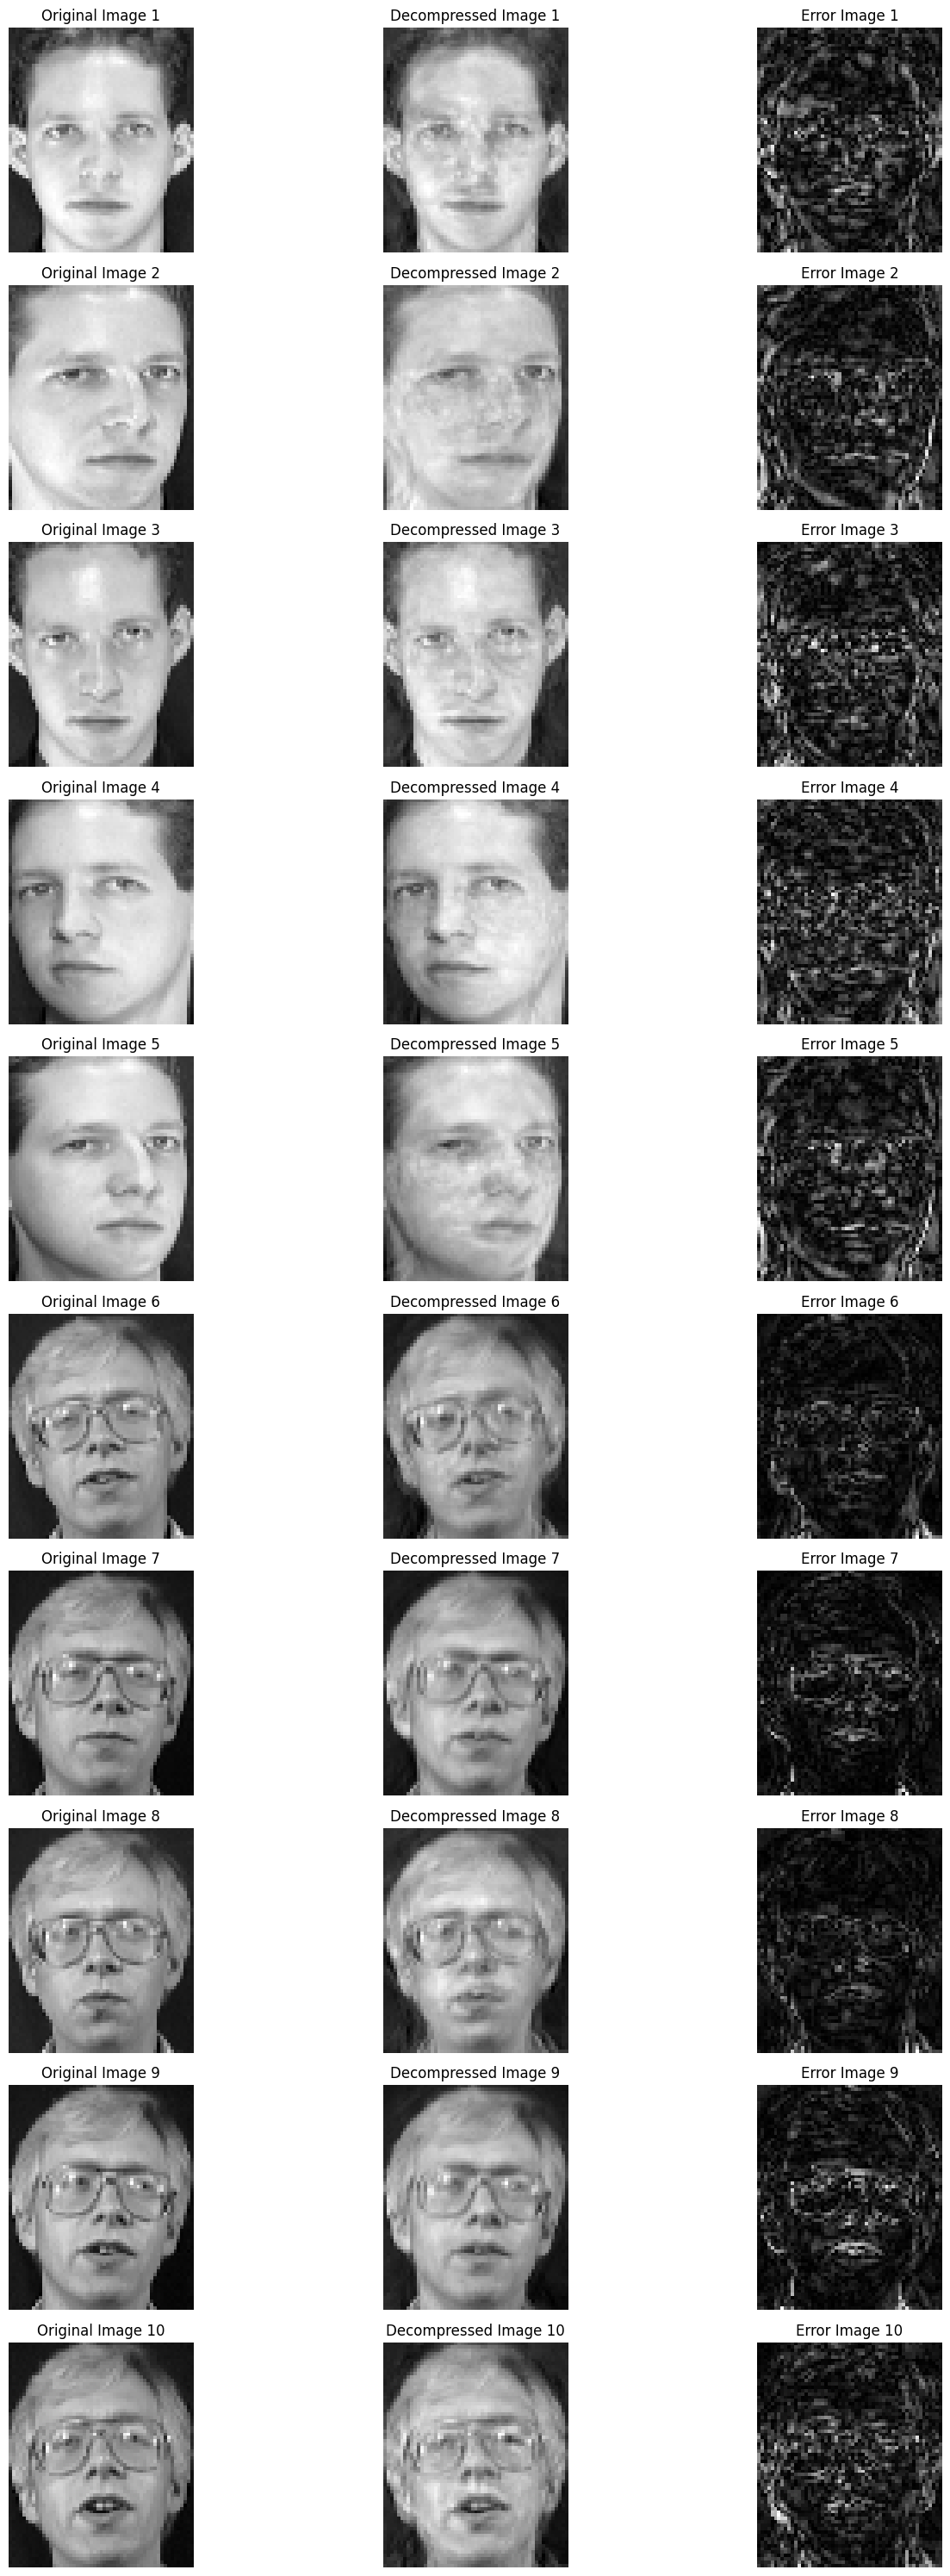

Average SSD Error: 4.393984915897152


In [142]:
import matplotlib.pyplot as plt

error_images = []
num_display = 10  # 只显示前10张图像

# 创建一个包含num_display行、3列的子图网格
fig, axes = plt.subplots(num_display, 3, figsize=(15, 3 * num_display))

for idx, image in enumerate(train_image_list[:num_display]):
    # 将图像展平为向量
    image_vector = image.flatten()

    # 中心化
    normalized_vector = image_vector - mean

    # 压缩图像：将图像投影到前k个特征向量上
    compressed_image = eigenvectors.T @ normalized_vector  # 压缩后的向量长度为k

    # 解压缩图像：将压缩向量重构回原始维度并加回均值
    decompressed_image = eigenvectors @ compressed_image + mean  # 重构后的图像向量

    # 计算重构误差图像
    error_image = np.abs(decompressed_image - image_vector)
    error_images.append(error_image)

    # 重新将图像和误差图像reshape回原来的维度
    image_reshaped = image.reshape(h, w)
    decompressed_reshaped = decompressed_image.reshape(h, w)
    error_image_reshaped = error_image.reshape(h, w)

    # 在并排的子图中显示原始图像、解压缩图像和误差图像
    axes[idx, 0].imshow(image_reshaped, cmap='gray')
    axes[idx, 0].set_title(f"Original Image {idx+1}")
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(decompressed_reshaped, cmap='gray')
    axes[idx, 1].set_title(f"Decompressed Image {idx+1}")
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(error_image_reshaped, cmap='gray')
    axes[idx, 2].set_title(f"Error Image {idx+1}")
    axes[idx, 2].axis('off')

    print(f"Image {idx+1}: Size before compression: {image.nbytes} Bytes")
    print(f"Image {idx+1}: Size after compression: {compressed_image.nbytes} Bytes")

plt.tight_layout()
plt.show()

# 计算所有图像的平均平方误差
error_images = np.stack(error_images, axis=0)
ssd_error = (error_images**2).sum(axis=-1).mean()
print('Average SSD Error:', ssd_error)


# Part B: Face Detection with PCA
**In this part we will use PCA to detect faces.** In previous part, we have implemented a compressor for face images. Since the eigenvectors are extracted from faces images, we can expect that such a compressor would fail on other images, leading to erroneous decompression. This fact can be used for face detection.

You are given an image with a face and your task is to find the location (x coordinate) of the face.
Try to compress and then decompress each part of the image using the method in part A, and then compute the SSD error. Based on the SSD error, find the localtion (x coordinate) where the face is located.

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20339 (\N{CJK UNIFIED IDEOGRAPH-4F73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


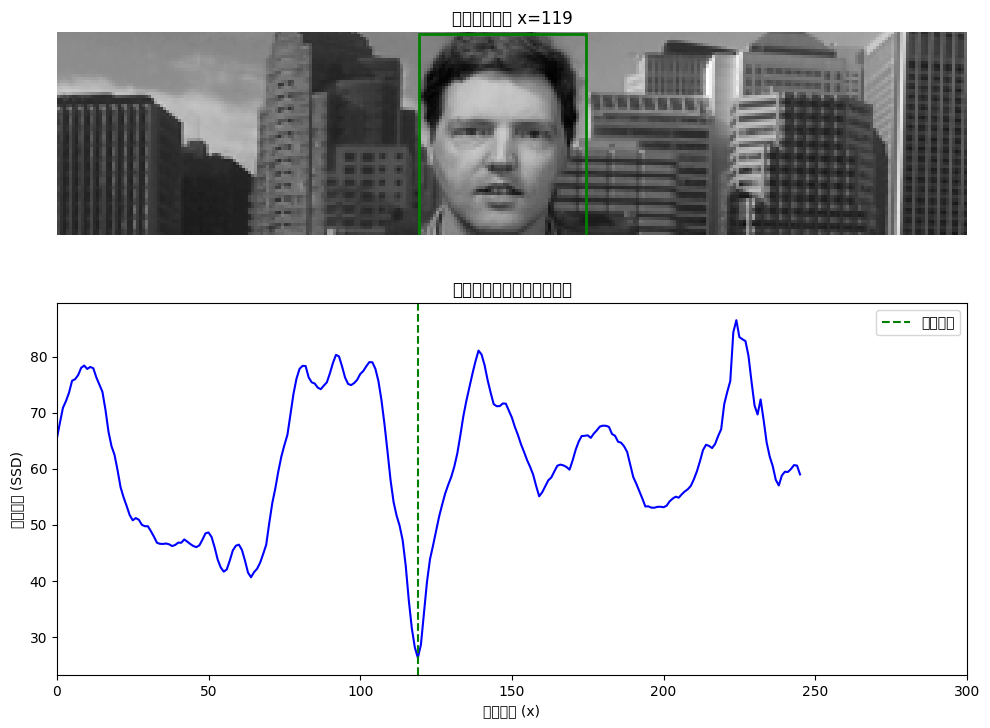

最佳窗口位置在 x = 119，对应的最小重构误差为 26.24673179724541


In [143]:
# 假设已经定义了以下变量：
# eigenvectors: 从之前的PCA中得到的特征向量，形状为 (原始维度, num_eigenvectors)
# w: 窗口的宽度
# h: 窗口的高度
import matplotlib.patches as patches
# 这里假设 w 和 h 已经定义，例如：
w, h = 55, 67  # 根据需要调整窗口大小

# 读取并预处理图像
image = imread('FaceDetection.bmp')[:h, :]/255.0  # 读取图像并归一化
h_, w_ = image.shape

errors = []

# 遍历图像的每一个可能的窗口位置
for x in range(w_ - w + 1):
    # 截取当前窗口的图像块并展平为向量
    image_crop = image[:, x:x + w].flatten()
    
    # 中心化
    normalized_crop = image_crop - mean
    
    # 压缩图像块：将图像向量投影到特征空间
    compressed = eigenvectors.T @ normalized_crop  # 得到压缩后的向量，长度为 num_eigenvectors
    
    # 解压缩图像块：将压缩向量重构回原始维度并加回均值
    decompressed = eigenvectors @ compressed + mean  # 重构后的图像向量
    
    # 计算重构误差（均方误差）
    error = np.linalg.norm(decompressed - image_crop) ** 2
    errors.append(error)
    
    # 可视化当前窗口和误差曲线
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    
    # 在原始图像上绘制当前窗口的矩形
    rect = patches.Rectangle((x, 0), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax[0].imshow(image, cmap='gray')
    ax[0].add_patch(rect)
    ax[0].set_title('当前窗口位置')
    ax[0].axis('off')
    
    # 绘制误差曲线
    ax[1].plot(range(len(errors)), errors, color='b')
    ax[1].set_title('重构误差随窗口位置的变化')
    ax[1].set_xlabel('窗口位置 (x)')
    ax[1].set_ylabel('重构误差 (SSD)')
    ax[1].set_xlim([0, w_])
    
    # 动态刷新输出
    plt.tight_layout()
    clear_output(wait=True)
    plt.show()

# 找到误差最小的窗口位置
x_best = np.argmin(errors)

# 可视化最佳窗口位置和误差曲线
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# 在原始图像上绘制最佳窗口的绿色矩形
rect = patches.Rectangle((x_best, 0), w, h, linewidth=2, edgecolor='g', facecolor='none')
ax[0].imshow(image, cmap='gray')
ax[0].add_patch(rect)
ax[0].set_title(f'最佳窗口位置 x={x_best}')
ax[0].axis('off')

# 绘制误差曲线
ax[1].plot(range(len(errors)), errors, color='b')
ax[1].axvline(x=x_best, color='g', linestyle='--', label='最佳位置')
ax[1].set_title('重构误差随窗口位置的变化')
ax[1].set_xlabel('窗口位置 (x)')
ax[1].set_ylabel('重构误差 (SSD)')
ax[1].set_xlim([0, w_])
ax[1].legend()

plt.tight_layout()
clear_output(wait=True)
plt.show()

print(f'最佳窗口位置在 x = {x_best}，对应的最小重构误差为 {errors[x_best]}')


# Part C: Exam question

![alt](exam_question.png)